import libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

load dataset

In [2]:
# Load the MNIST dataset with the help of the api provided in the Keras library.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Shuffle the training data and print the dimensions of the data.

In [3]:
np.random.seed(0) 
np.random.shuffle(x_train)
np.random.seed(0)
np.random.shuffle(y_train)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


Show the first 10 images in the training data set along with their labels.

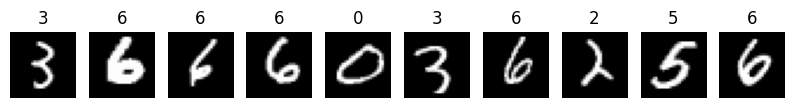

In [4]:
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(y_train[i])
    ax.axis('off')
plt.show()

Change the values of the pixels to the range of 0 to 1.

In [5]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Change labels to categorical form.

In [6]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

define and train model

In [7]:
# Design and train a neural network with the following features:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name="last_conv")) # adding name because we need it in the Grad-CAM part
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Train the built model with the following specifications:
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(x_train.reshape(-1, 28, 28, 1), y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/15
938/938 [==============================] - 17s 7ms/step - loss: 0.1671 - accuracy: 0.9492 - val_loss: 0.0622 - val_accuracy: 0.9801
Epoch 2/15
938/938 [==============================] - 5s 6ms/step - loss: 0.0447 - accuracy: 0.9859 - val_loss: 0.0357 - val_accuracy: 0.9887
Epoch 3/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0319 - accuracy: 0.9903 - val_loss: 0.0308 - val_accuracy: 0.9908
Epoch 4/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0245 - accuracy: 0.9920 - val_loss: 0.0301 - val_accuracy: 0.9904
Epoch 5/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0184 - accuracy: 0.9940 - val_loss: 0.0396 - val_accuracy: 0.9889
Epoch 6/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0164 - accuracy: 0.9949 - val_loss: 0.0397 - val_accuracy: 0.9895
Epoch 7/15
938/938 [==============================] - 5s 6ms/step - loss: 0.0131 - accuracy: 0.9956 - val_loss: 0.0282 - val_accuracy: 0.9918
Epoch

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 last_conv (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

In [9]:
model.layers[-5].name

'last_conv'

Run the Grad-CAM algorithm on the last convolutional layer and show its output for 10 sample images.

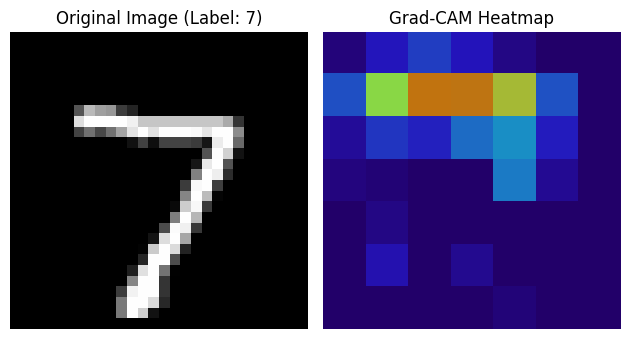

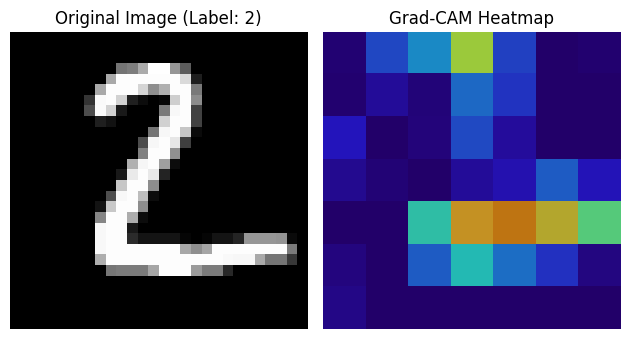

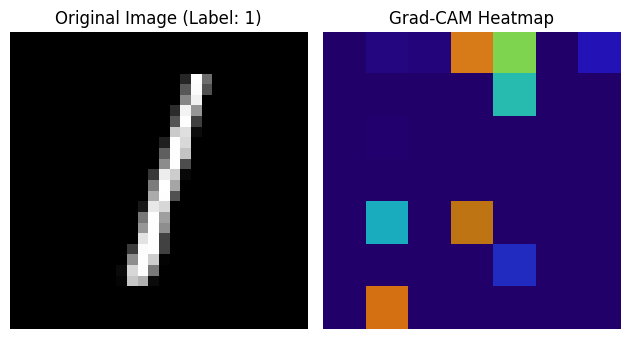

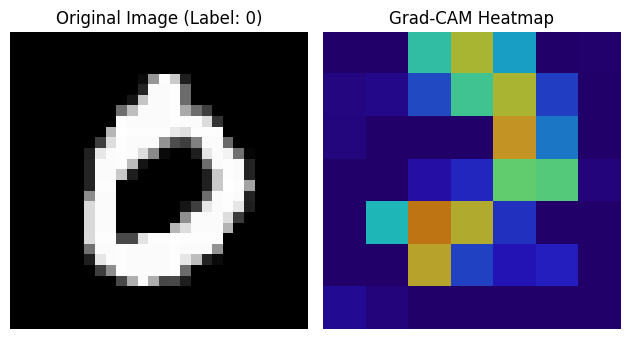

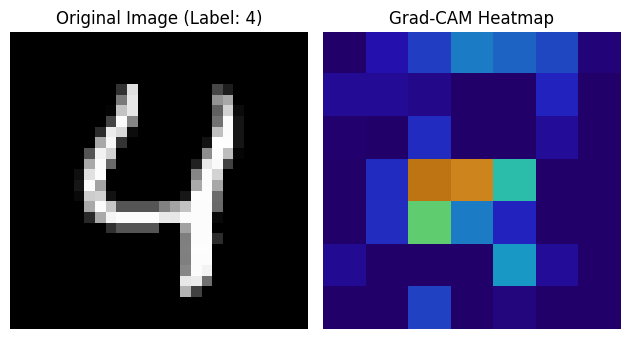

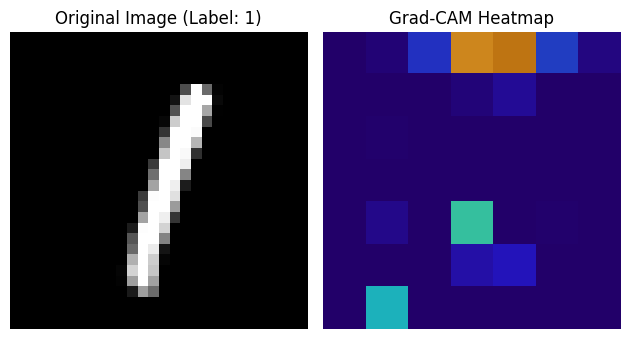

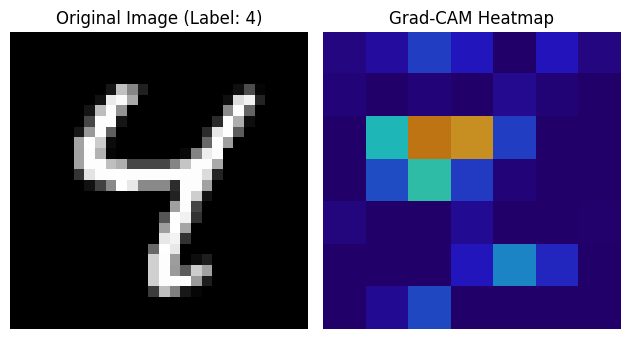

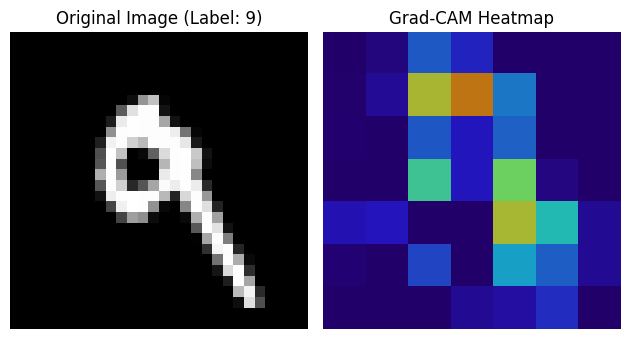

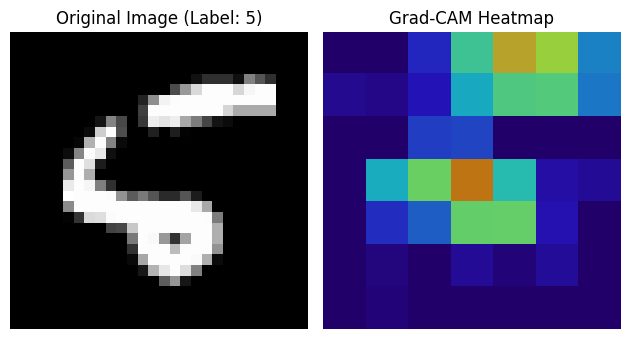

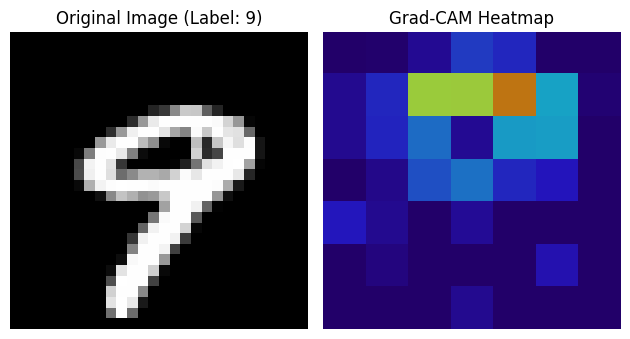

In [11]:
# Analyze the output of the algorithm and examine the result of using Grad-CAM in identifying important features in MNIST images.

last_conv_layer = model.get_layer('last_conv')
# last_conv_layer = model.layers[-5]

grad_model = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])

with tf.GradientTape() as tape:
    predictions, conv_outputs = grad_model(x_test[:10].reshape(-1, 28, 28, 1))
    loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Apply Grad-CAM on 10 sample images
for idx in range(10):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f"Original Image (Label: {np.argmax(y_test[idx])})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap[idx])
    plt.imshow(heatmap[idx], cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.tight_layout()

plt.show()
